<h1><b>Dask</b></h1>

Dask is a flexible library for parallel computing in Python.

Dask is composed of two parts:
<ul>
    <li>
Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
    </li>
    <li>
“Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.
    </li>
</ul>


Dask emphasizes the following virtues:
<ul>
    <li>
Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
</li>
    <li>
Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
</li>
    <li>
Native: Enables distributed computing in pure Python with access to the PyData stack.
</li>
    <li>
Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
</li>
    <li>
Scales up: Runs resiliently on clusters with 1000s of cores
</li>
    <li>
Scales down: Trivial to set up and run on a laptop in a single process
</li>
    <li>
Responsive: Designed with interactive computing in mind, it provides rapid feedback and diagnostics to aid humans
       </li>
</ul>
<img src="dask-overview.svg" width="90%">

# Familiar User Interface:

# Dask DataFrame mimics Pandas - [documentation](https://docs.dask.org/en/stable/dataframe.html)

In [13]:
import pandas as pd                     
df = pd.read_csv('data/accounts.0.csv')      
df.groupby(df.id).amount.mean()    

id
0       514.666667
1      2076.659751
2       558.344272
3       644.715183
4       249.428571
          ...     
495    2069.396916
496    1965.103219
497     464.691765
498      90.948468
499      26.029795
Name: amount, Length: 500, dtype: float64

In [12]:
df.head()

,id,names,amount
0,155,Ingrid,1486
1,450,Laura,628
2,363,Dan,995
3,389,Sarah,-48
4,188,Ray,426


In [14]:
import dask.dataframe as dd
df = dd.read_csv('data/accounts.0.csv')
df.groupby(df.id).amount.mean().compute()

id
0       514.666667
1      2076.659751
2       558.344272
3       644.715183
4       249.428571
          ...     
495    2069.396916
496    1965.103219
497     464.691765
498      90.948468
499      26.029795
Name: amount, Length: 500, dtype: float64

In [15]:
df.head()

,id,names,amount
0,155,Ingrid,1486
1,450,Laura,628
2,363,Dan,995
3,389,Sarah,-48
4,188,Ray,426


# Dask Array mimics NumPy - [documentation](https://docs.dask.org/en/stable/array.html)

In [17]:

import numpy as np 
import h5py
f = h5py.File('data/weather-small/2014-01-01.hdf5')             
x = np.array(f['t2m'])           
                                                           
x - np.array([x.mean(axis=1) for y in range(360)]).T

array([[-3.03194444, -3.03194444, -3.03194444, ..., -3.03194444,
        -3.03194444, -3.03194444],
       [-3.64791667, -3.64791667, -3.64791667, ..., -2.64791667,
        -2.64791667, -3.64791667],
       [ 0.39444444, -0.10555556, -0.10555556, ...,  0.39444444,
         0.39444444,  0.39444444],
       ...,
       [ 2.98611111,  2.98611111,  2.98611111, ...,  3.73611111,
         2.98611111,  2.98611111],
       [ 3.71527778,  3.71527778,  4.21527778, ...,  3.71527778,
         3.71527778,  3.71527778],
       [ 2.05138889,  2.05138889,  2.05138889, ...,  2.30138889,
         2.30138889,  2.30138889]])

In [8]:
f = h5py.File('data/weather-small/2014-01-01.hdf5') 
f['t2m']

<HDF5 dataset "t2m": shape (180, 360), type "<f8">

In [21]:
import dask.array as da
f = h5py.File('data/weather-small/2014-01-01.hdf5')
x = da.from_array(f['t2m'],chunks=(1000, 1000))
z = x - da.from_array([x.mean(axis=1).compute() for y in range(360)]).T
z.compute()

array([[-3.03194444, -3.03194444, -3.03194444, ..., -3.03194444,
        -3.03194444, -3.03194444],
       [-3.64791667, -3.64791667, -3.64791667, ..., -2.64791667,
        -2.64791667, -3.64791667],
       [ 0.39444444, -0.10555556, -0.10555556, ...,  0.39444444,
         0.39444444,  0.39444444],
       ...,
       [ 2.98611111,  2.98611111,  2.98611111, ...,  3.73611111,
         2.98611111,  2.98611111],
       [ 3.71527778,  3.71527778,  4.21527778, ...,  3.71527778,
         3.71527778,  3.71527778],
       [ 2.05138889,  2.05138889,  2.05138889, ...,  2.30138889,
         2.30138889,  2.30138889]])

# Dask Bag mimics iterators, Toolz, and PySpark - [documentation](https://docs.dask.org/en/stable/bag.html)

In [3]:
import dask.bag as db
import json
b = db.read_text('data/accounts.01.json.gz').map(json.loads)
b.pluck('name').frequencies().topk(10, lambda pair: pair[1]).compute()

[('Yvonne', 30),
 ('Ingrid', 28),
 ('Ray', 26),
 ('Tim', 24),
 ('Frank', 23),
 ('Bob', 22),
 ('Jerry', 22),
 ('Edith', 21),
 ('Quinn', 21),
 ('George', 21)]

In [8]:
b = db.read_text('data/accounts.01.json.gz').map(json.loads)
b.pluck('name').frequencies().take(1)

(('Bob', 22),)

In [26]:
from pyspark import SparkContext
import json
# sc = SparkContext("local", "Collect app")
rdd2 = sc.textFile("data/accounts.01.json.gz")
rdd2.show(1)

AttributeError: 'RDD' object has no attribute 'show'

# Dask Delayed mimics for loops and wraps custom code - [documentation](https://docs.dask.org/en/stable/delayed.html)


# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

In [27]:
from dask.distributed import Client

client = Client(n_workers=4)

C:\Users\Rahul\anaconda3\envs\dask-tutorial\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53322 instead
  warnings.warn(


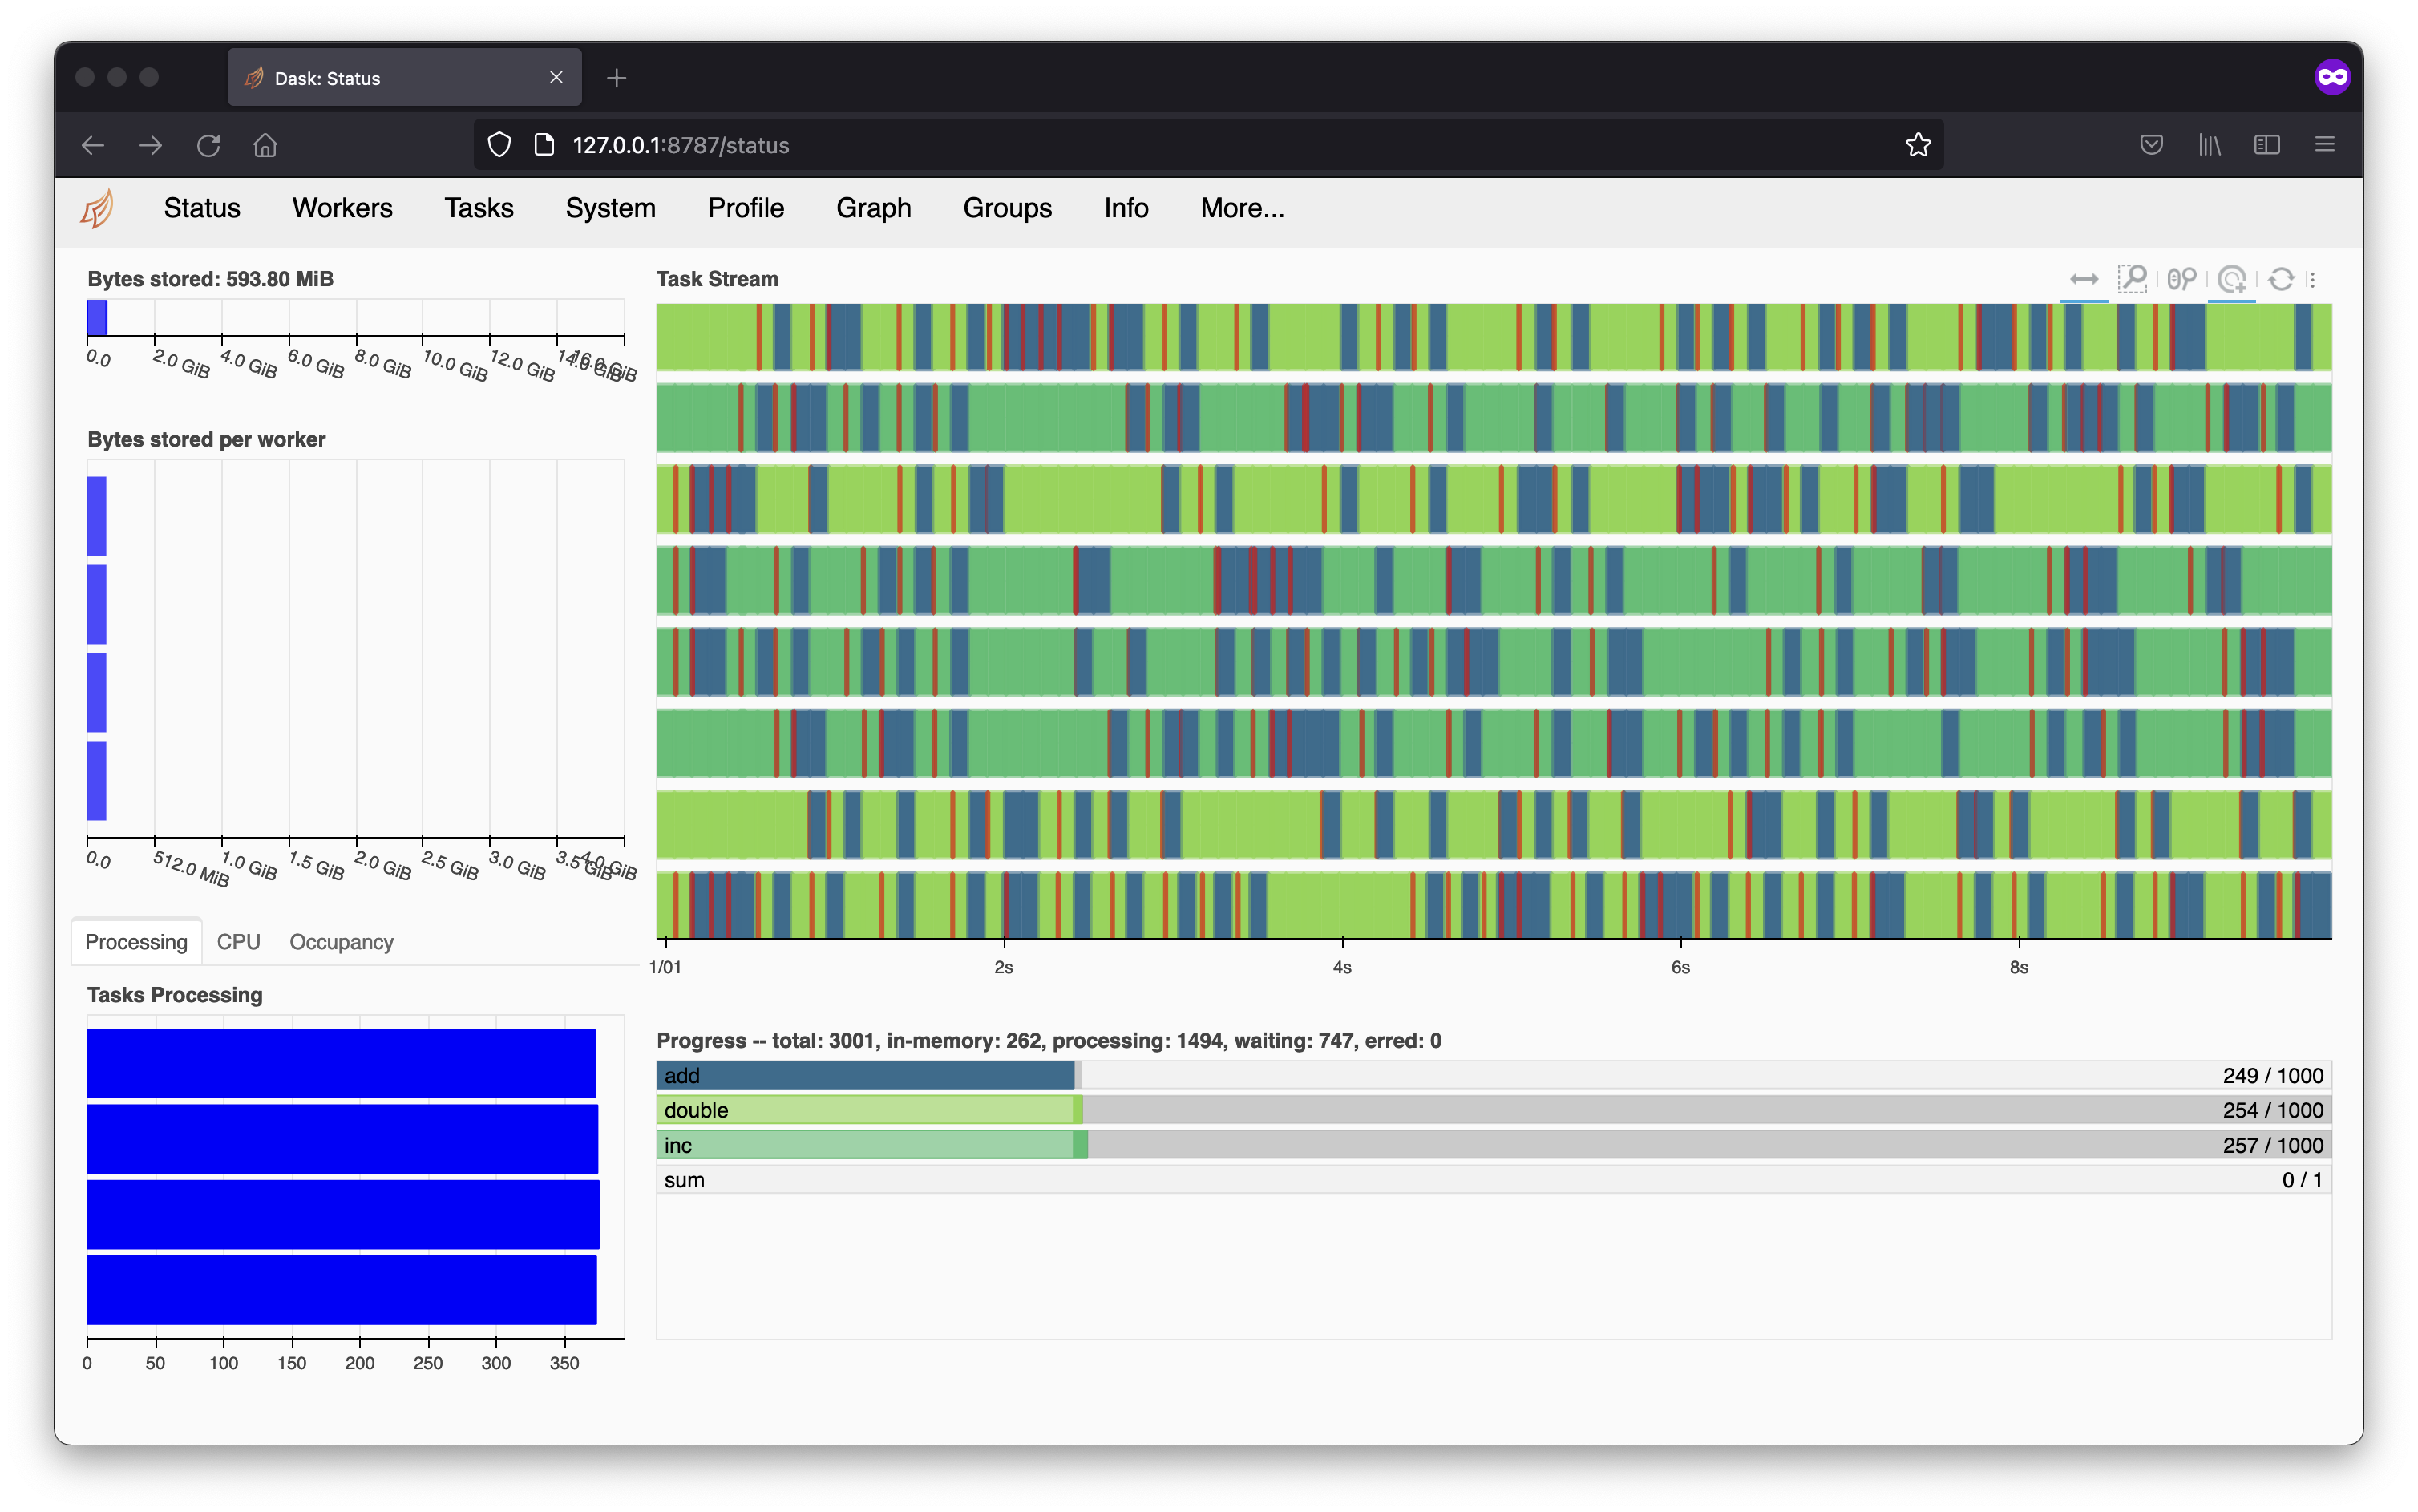

In [28]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [30]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [31]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: total: 203 ms
Wall time: 8.08 s


Before computing: Delayed('sum-0358f024-e308-4294-a6ff-91517e229d72')
After computing : 44
CPU times: total: 703 ms
Wall time: 1.84 s


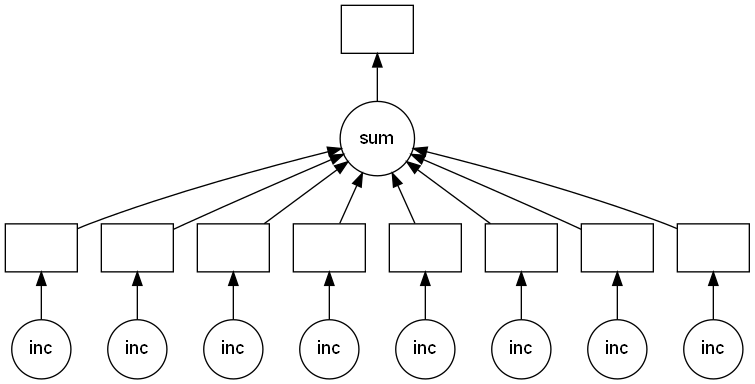

In [33]:
%%time
from dask import delayed
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is

result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

# The concurrent.futures interface provides general submission of custom tasks: - [documentation](https://docs.dask.org/en/stable/futures.html)

In [ ]:
from dask.distributed import Client
client = Client('scheduler:port')

futures = []
for fn in filenames:
    future = client.submit(load, fn)
    futures.append(future)

summary = client.submit(summarize, futures)
summary.result()